# Проект: Повышение активности постоянных покупателей.

**Описание проекта:** Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых покупателей - не вариант, так как целевая аудитория уже знает про магазин. Возможный выход - повысить активность постоянных покупателей. Это можно сделать при помощи специализированных предложений.

**Цель исследования:**  Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход работы:**
- [Загрузка данных (подгрузить данные и первично оценить их)](#upload)
- [Предобработка данных (сделать данные более чистыми, если нужно)](#prep)
- [Исследовательский анализ данных (посмотреть на закономерности, зависимости)](#research)
- [Объединить таблицы для удобства](#merge)
- [Корреляционный анализ (взглянуть на корреляцию)](#corr)
- [Сделать пайплайны](#pipe)
- [Проанализировать важность признаков](#importance)
- [Сегментировать покупателей](#segment)
- [Итоговые выводы](#res)

<a id='upload'></a>
## Загрузка данных.

Импортируем все, что нам понадобится:

In [1]:
!pip install phik
!pip install shap==0.41.0 matplotlib==3.5.0 scikit-learn==1.1.3 numpy==1.23.5 pandas==1.5.3
import phik
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import shap

     |████████████████████████████████| 677 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 572 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 67.1 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 49.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 81.6 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 934 kB/s  eta 0:00:01
     |████████████████████████████████| 3.7 MB 49.2 MB/s eta 0:00:01
     |████████████████████████████████| 43.9 MB 56.8 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.0
    Uninstalling llvmlite-0.39.0:
      Successfully uninstalled llvmlite-0

Для удобства, напишем функцию, с помощью которой будем подгружать данные:

In [2]:
def upload_function(data, sep, decimal):
    try:
        info = pd.read_csv(f'/datasets/{data}.csv', sep=sep, decimal=decimal)
    except: 
        info = pd.read_csv(f'https://code.s3.yandex.net/datasets/{data}.csv', sep=sep, decimal=decimal)
    return info

Приступим к подгрузке данных:

In [3]:
market_file = upload_function('market_file', ',', ',')
market_money = upload_function('market_money', ',', ',')
market_time = upload_function('market_time', ',', ',')
money = upload_function('money', ';', ',')

Проверим, что данные в таблицах соответствуют описанию:

In [4]:
data_list = [market_file, market_money, market_time, money]
for i  in data_list:
    print(i.head(), '\n\n', i.describe(), '\n\n')

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность Акционные_покупки  \
0                3.4                     5           121               0.0   
1                4.4                     4           819              0.75   
2                4.9                     3           539              0.14   
3                3.2                     5           896              0.99   
4                5.1                     3          1064              0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                         

Данные соответствуют описанию, пропусков, на первый взгляд, тоже нет, взглянем на все это более детально в предобработке.

<a id='prep'></a>
## Предобработка данных.

In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [6]:
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [7]:
market_file.duplicated().sum()

0

In [8]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [9]:
mf_list = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
for i in mf_list:
    print(market_file[i].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [10]:
market_file.loc[market_file['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [11]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [12]:
market_file['Маркет_актив_6_мес'] = market_file['Маркет_актив_6_мес'].astype('float')
market_file['Акционные_покупки'] = market_file['Акционные_покупки'].astype('float')

Пропусков нет, явных дубликатов тоже. Неявный дубликат в столбце с типом сервиса был обработан, данные в столбцах активности маркета за полгода и доли акционных покупок приведены к числовому виду, в остальном данные чистые. Взглянем на остальные:

In [13]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


In [14]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [15]:
market_money.duplicated().sum()

0

In [16]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

В целом, во второй таблице все хорошо, но, думаю, лучше привести столбец "Выручки" к числовому типу:

In [17]:
market_money['Выручка'] = market_money['Выручка'].astype('float')

Идем дальше:

In [18]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [19]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [20]:
market_time.duplicated().sum()

0

In [21]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Есть опечатка, обработаем ее:

In [22]:
market_time.loc[market_time['Период']=='предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Осталась последняя:

In [23]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [24]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [25]:
money.duplicated().sum()

0

Все предоставленные данные оказались достаточно чистыми, отлично! Однако, кое-что пришлось подправить - тип значений у выручки, неявный дубликат у типа сервиса в первой таблице, а также исправлена небольшая опечатка в третьей в столбце периода. Приступим к исследовательскому анализу.

<a id='research'></a>
## Исследовательский анализ.

Приступим к исследованию наших датасетов. 

Начнем с *market_file*:

In [26]:
for i in market_file.columns:
    print(i, '\n', market_file[i].describe(), '\n\n')

id 
 count      1300.000000
mean     215997.500000
std         375.421985
min      215348.000000
25%      215672.750000
50%      215997.500000
75%      216322.250000
max      216647.000000
Name: id, dtype: float64 


Покупательская активность 
 count                1300
unique                  2
top       Прежний уровень
freq                  802
Name: Покупательская активность, dtype: object 


Тип сервиса 
 count         1300
unique           2
top       стандарт
freq           924
Name: Тип сервиса, dtype: object 


Разрешить сообщать 
 count     1300
unique       2
top         да
freq       962
Name: Разрешить сообщать, dtype: object 


Маркет_актив_6_мес 
 count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64 


Маркет_актив_тек_мес 
 count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%        

In [27]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

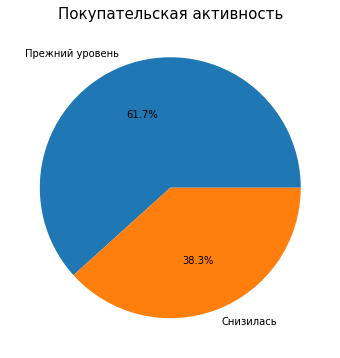

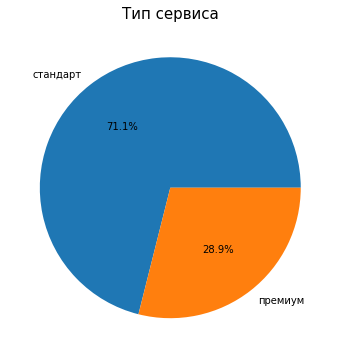

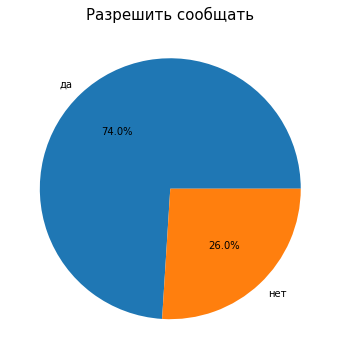

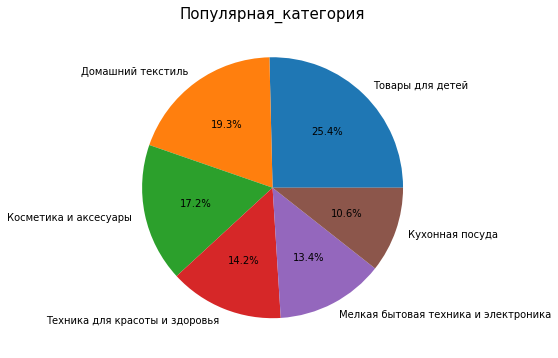

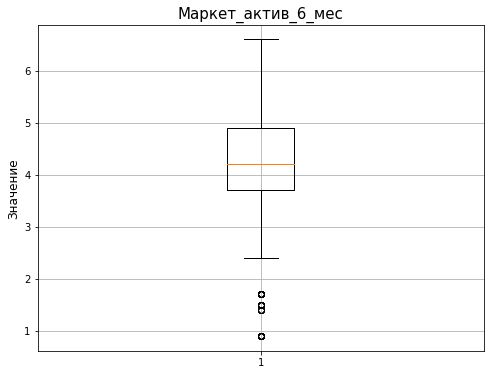

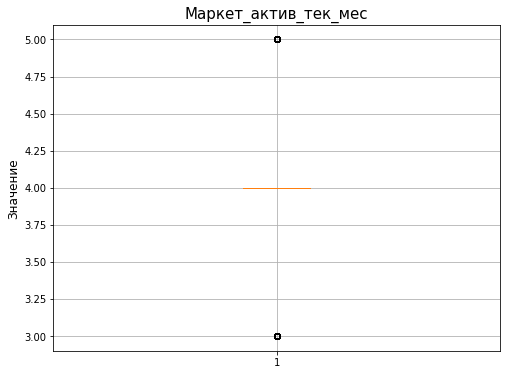

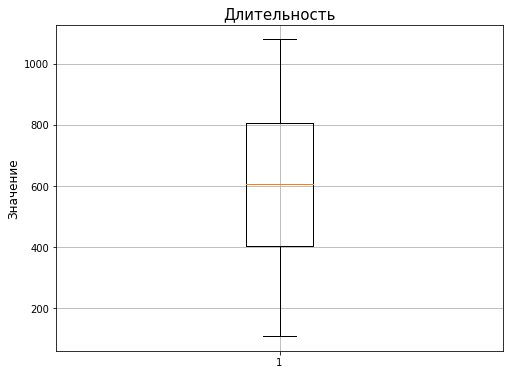

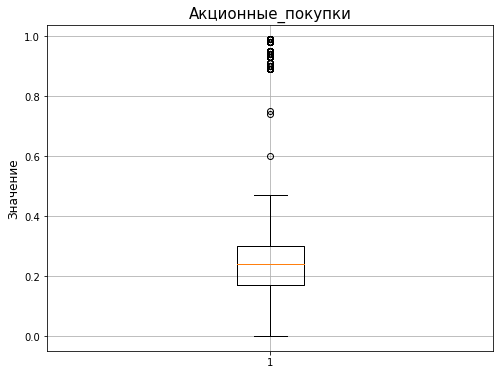

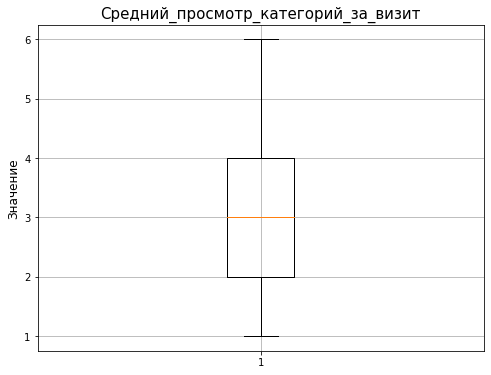

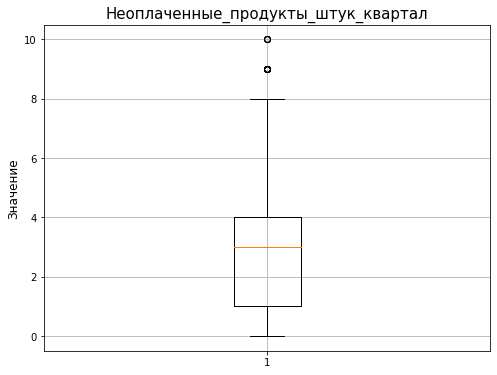

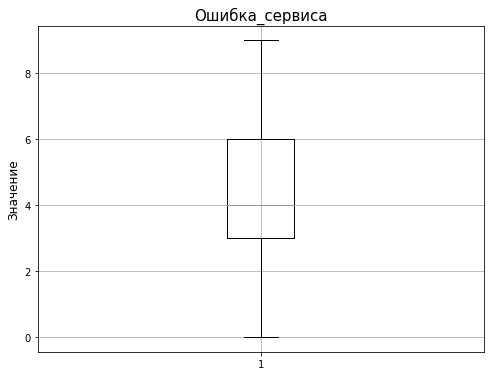

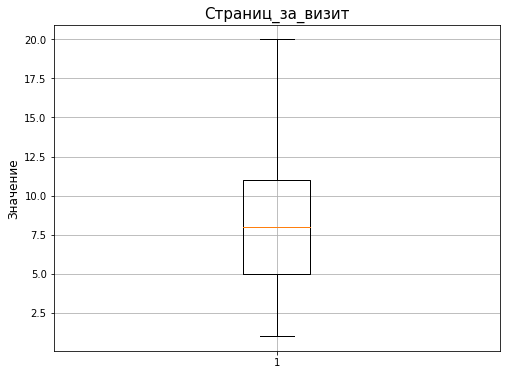

In [28]:
mf_cat_list = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
mf_num_list = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']

for i in mf_cat_list:
    plt.figure(figsize=(6,6))
    plt.pie(market_file[i].value_counts(), 
            labels=market_file[i].value_counts().index,
            autopct='%1.1f%%' 
           )
    plt.title(i, fontsize=15)
    plt.show()
    
for i in mf_num_list:
    plt.figure(figsize=(8,6))
    plt.boxplot(market_file[i])
    plt.grid()
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()

Более детальный смотр для количественных признаков:

In [29]:
for i in mf_num_list:
    print(i, market_file[i].unique())

Маркет_актив_6_мес [3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9]
Маркет_актив_тек_мес [5 4 3]
Длительность [ 121  819  539  896 1064  762  431  284  192  154  450  110  623  199
  438  923  708  167  209  581  829  607  572  365  566  811  268  558
  534  730  488  436  637  554  330  504 1020  721  495  135  663 1047
  152  754  525  169  966  645  706  689  882 1007  304  339  954  771
  699  669  511  974  666  857 1048  756  506  759  768  720  219  377
  472  806  449  523  503  515  813  249  186  336  690  824  753  674
  875  844  602  855  448  344  922  298  893  881  372  788  937  764
  851 1021  627  748  684  719  891  842  573 1057  342  638  458  254
  600  871  574  982  324  373  839  845  475  509  252  820  744  541
 1079  900  474  957  773  717  508  184  828  944  419  302  898  705
  953  355  616  622  335 1025  755  549  308  903  683  434 

In [30]:
mf_dis_list = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']
mf_cont_list = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки']

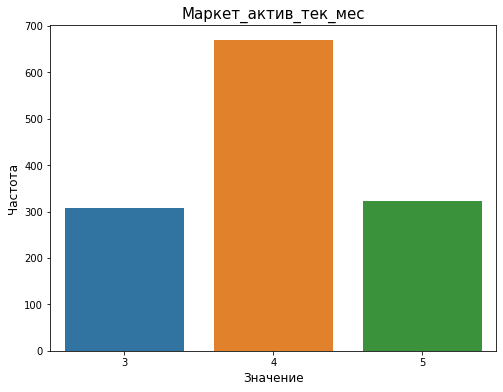

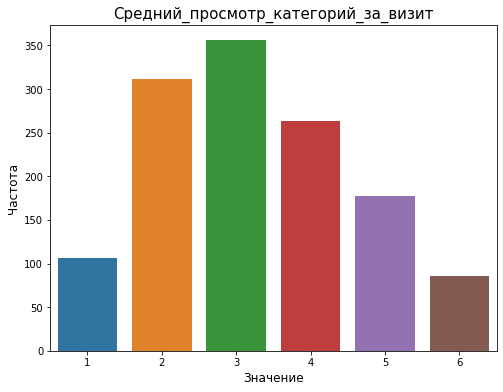

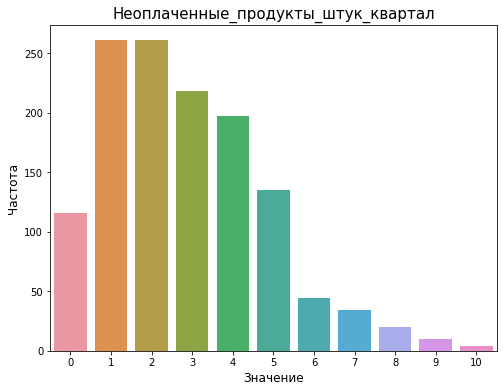

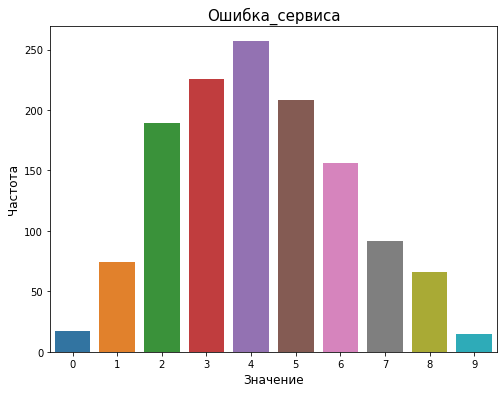

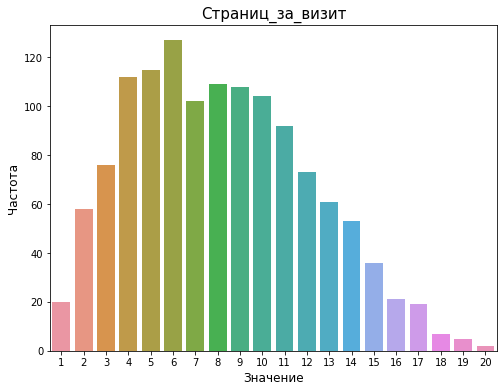

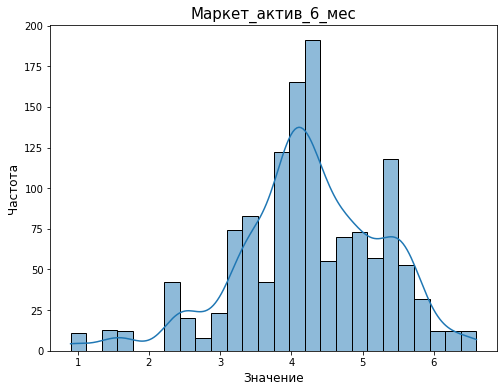

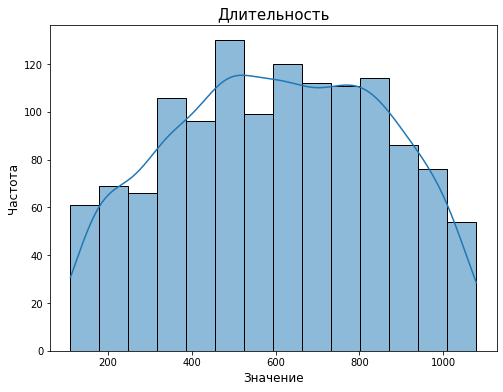

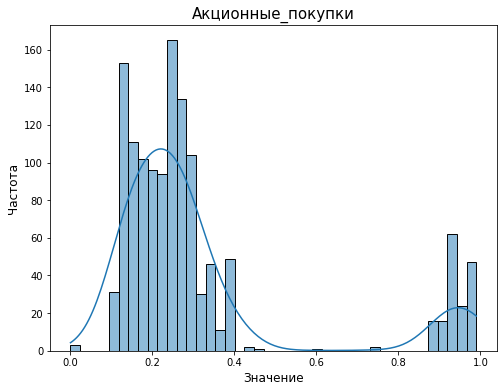

In [31]:
for i in mf_dis_list:
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.countplot(data=market_file, x=i)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

for i in mf_cont_list:
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.histplot(data=market_file, x=i, kde=True)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

Для датасета *market_money*:

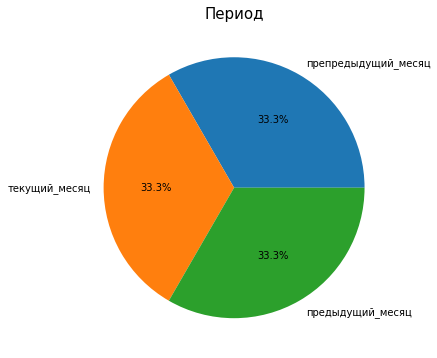

Text(0, 0.5, 'Частота')

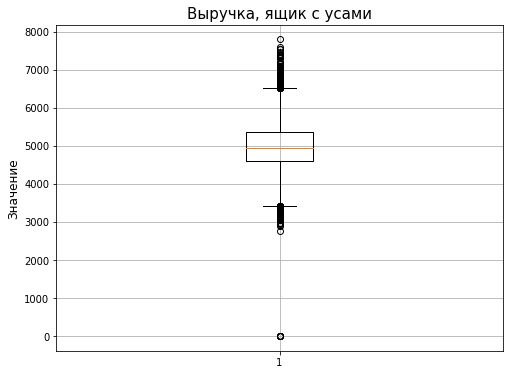

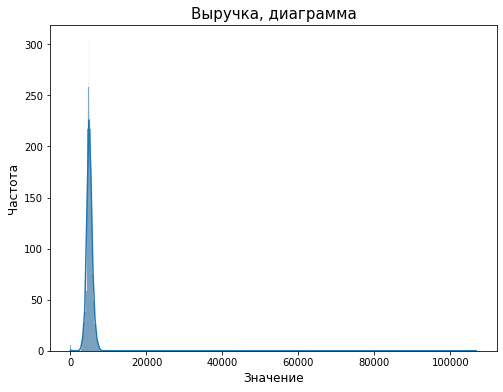

In [32]:
plt.figure(figsize=(6,6))
plt.pie(market_money['Период'].value_counts(),
        labels=market_money['Период'].value_counts().index,
        autopct='%1.1f%%'
       )
plt.title('Период', fontsize=15)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Выручка, ящик с усами', fontsize=15)
plt.boxplot(market_money['Выручка'].loc[market_money['Выручка'] <20000])
plt.ylabel('Значение', fontsize=12)
plt.grid()

plt.figure(figsize=(8,6))
plt.title('Выручка, диаграмма', fontsize=15)
sns.histplot(data=market_money, x='Выручка', kde=True)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

In [33]:
market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

In [34]:
market_money[market_money['Выручка']==106862.2]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Text(0, 0.5, 'Частота')

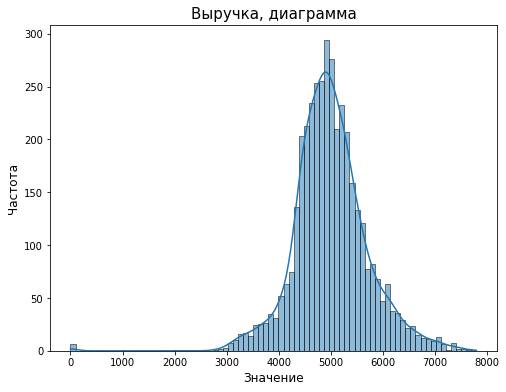

In [35]:
market_money.loc[98, 'Выручка'] = market_money['Выручка'].mean()
plt.figure(figsize=(8,6))
plt.title('Выручка, диаграмма', fontsize=15)
sns.histplot(data=market_money, x='Выручка', kde=True)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Для датасета *market_time*:

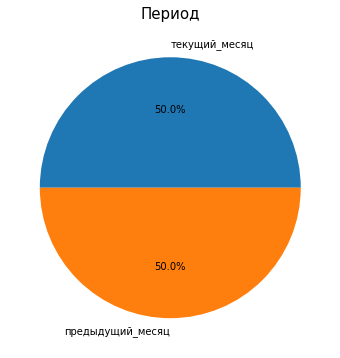

Text(0, 0.5, 'Частота')

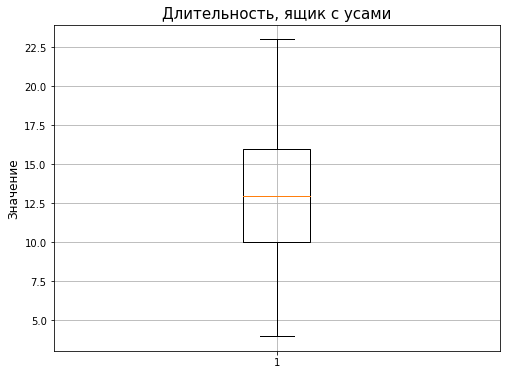

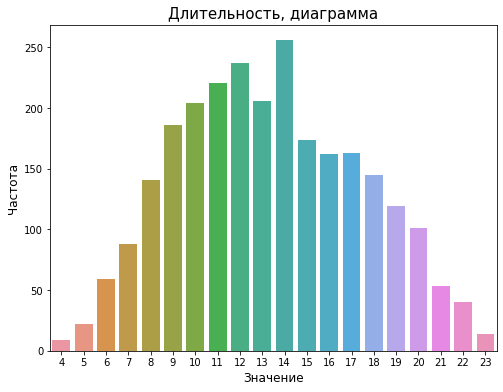

In [36]:
plt.figure(figsize=(6,6))
plt.pie(market_time['Период'].value_counts(),
        labels=market_time['Период'].value_counts().index,
        autopct='%1.1f%%'
       )
plt.title('Период', fontsize=15)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Длительность, ящик с усами', fontsize=15)
plt.boxplot(market_time['минут'])
plt.ylabel('Значение', fontsize=12)
plt.grid()

plt.figure(figsize=(8,6))
plt.title('Длительность, диаграмма', fontsize=15)
sns.countplot(data=market_time, x='минут')
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Для последнего датасета *money*:

In [37]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

Text(0, 0.5, 'Частота')

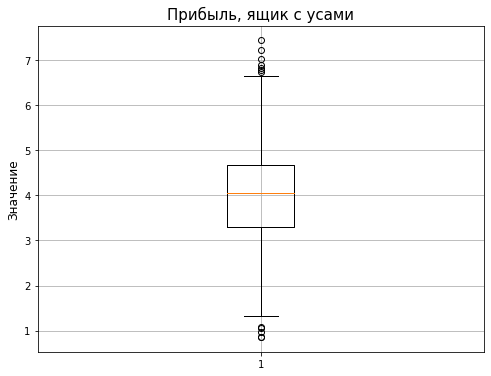

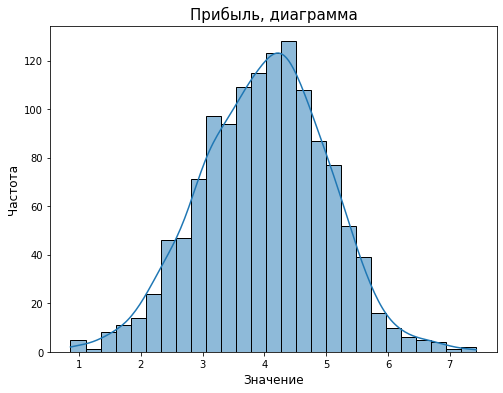

In [38]:
plt.figure(figsize=(8,6))
plt.title('Прибыль, ящик с усами', fontsize=15)
plt.boxplot(money['Прибыль'])
plt.ylabel('Значение', fontsize=12)
plt.grid()

plt.figure(figsize=(8,6))
plt.title('Прибыль, диаграмма', fontsize=15)
sns.histplot(data=money, x='Прибыль', kde=True)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)

**Промежуточные выводы:**

Датасет *market_file*:

*Качественные признаки*:
- Почти у 40% клиентов активность снизилась.
- Большинство клиентов используют стандартный тип сервиса (более 70%).
- Большинство клиентов получают рассылки (более 70%).
- Популярные категории не сильно отличаются между собой по количеству, тем не менее, самая большая - "Товары для детей" (25.4%), самая маленькая - "Мелкая бытовая техника и электроника" (13.4%).

*Количественные признаки*:
- В среднем, за последние полгода клиенты получали по 4 рассылки, в текущем месяце ситуация аналогичная, выбросов единицы.
- Медианное значение дней, сколько пользователь зарегистрирован на сайте - 600.
- Медианное значение доли акционных покупок за месяц - в районе 25%, есть небольшое количество выбросов. 
- За месяц пользователи просматривают в среднем 3 категории за визит.
- Неоплаченных товаров за последние три месяца в корзинах в среднем остается около трех.
- За последние три месяца медианное количество сбоев при нахождении на сайте - 125.
- Среднее количество просмотренных страниц за визит - в районе 8.

Датасет *market_money*:

- Три периода: предпредыдущий месяц, предыдущий и текущий, для каждого пользователя в равном соотношении.
- Медианное значение выручки - около 5000 условных единиц. Нельзя не отметить, что был единичный сильный выброс, значение которого составило 106862 единицы. Это может быть как ошибка в данных, так и действительно большая покупка. Для дальнейшего исследования, это значение было заменено на среднее по всему датасету.

Датасет *market_time*:

- Два периода - предыдущий и текущий месяцы.
- Медианное значение минут, сколько пользователи проводят на сайте - 13.

Датасет *money*:

- Медианное значение прибыли - 4 условные единицы.

Стоит отметить, что во всех количественных признаках если и есть выбросы, то их немного, что не может не радовать.

Теперь отберем тех клиентов, которые были активны в период последних трех месяцев:

In [39]:
market_money_active = market_money.groupby('id').filter(
    lambda group: group['Выручка'].eq(0).sum() == 0  # Нет нулей в выручке ни за один период
)
market_money_active.shape

(3891, 3)

In [40]:
market_money_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


In [41]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [42]:
print("Уникальных клиентов в исходных данных:", market_money['id'].nunique())
print("Уникальных клиентов после фильтрации:", market_money_active['id'].nunique())

Уникальных клиентов в исходных данных: 1300
Уникальных клиентов после фильтрации: 1297


Оказывается, что только три клиента не были активными в эти три месяца. Выбросим их из остальных таблиц тоже:

In [43]:
bad_ids = market_money.groupby('id').filter(
    lambda group: group['Выручка'].eq(0).any()
)['id'].unique()

In [44]:
market_file_active = market_file[~market_file['id'].isin(bad_ids)]
market_time_active = market_time[~market_time['id'].isin(bad_ids)]
money_active = money[~money['id'].isin(bad_ids)]

<a id='merge'></a>
## Объединение таблиц.

In [45]:
final_data0 = market_file_active.merge(market_money_active, on='id', how='left')
final_data0 = final_data0.merge(market_time_active, on=['id', 'Период'], how='left')
final_data0.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Период,Выручка,минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,препредыдущий_месяц,4472.0,NaN
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,текущий_месяц,4971.6,10.0
2,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,предыдущий_месяц,5216.0,12.0
3,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,препредыдущий_месяц,4826.0,NaN
4,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,текущий_месяц,5058.4,13.0
5,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,предыдущий_месяц,5457.5,8.0
6,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,текущий_месяц,6610.4,13.0
7,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,предыдущий_месяц,6158.0,11.0
8,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,препредыдущий_месяц,4793.0,NaN
9,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,предыдущий_месяц,5807.5,8.0


In [46]:
money_pivot = market_money_active.pivot_table(index='id', columns='Период', values='Выручка')
money_pivot.columns = ['Выручка предыдущий', 'Выручка предпредыдущий', 'Выручка текущий']
money_pivot

,Выручка предыдущий,Выручка предпредыдущий,Выручка текущий
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [47]:
time_pivot = market_time_active.pivot_table(index='id', columns='Период', values='минут')
time_pivot.columns = ['Минут предыдущий', 'Минут текущий']
time_pivot

,Минут предыдущий,Минут текущий
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [48]:
final_data1 = final_data0.merge(money_pivot, on='id', how='left')
final_data2 = final_data1.merge(time_pivot, on='id', how='left')
final_data2

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,Период,Выручка,минут,Выручка предыдущий,Выручка предпредыдущий,Выручка текущий,Минут предыдущий,Минут текущий
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,препредыдущий_месяц,4472.0,NaN,5216.0,4472.0,4971.6,12,10
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,текущий_месяц,4971.6,10.0,5216.0,4472.0,4971.6,12,10
2,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,предыдущий_месяц,5216.0,12.0,5216.0,4472.0,4971.6,12,10
3,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,препредыдущий_месяц,4826.0,NaN,5457.5,4826.0,5058.4,8,13
4,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,текущий_месяц,5058.4,13.0,5457.5,4826.0,5058.4,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3886,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,...,5,7,препредыдущий_месяц,4725.0,NaN,4923.0,4725.0,5224.6,18,7
3887,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,...,5,7,предыдущий_месяц,4923.0,18.0,4923.0,4725.0,5224.6,18,7
3888,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,...,3,12,предыдущий_месяц,4720.0,15.0,4720.0,5183.0,4448.3,15,10
3889,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,...,3,12,препредыдущий_месяц,5183.0,NaN,4720.0,5183.0,4448.3,15,10


In [49]:
final_data = final_data2.drop(['Период', 'Выручка', 'минут'], axis=1).drop_duplicates().reset_index(drop=True)
final_data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка предыдущий,Выручка предпредыдущий,Выручка текущий,Минут предыдущий,Минут текущий
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


Объединили таблицы, перевели выручку и минуты за каждый период в отдельные столбы, затем избавились от дубликатов, которые появились в следствие объединения через *merge*. Пришло время для корреляционного анализа.

<a id='corr'></a>
## Корреляционный анализ.

Построим матрицу корреляции для нашего датасета: 

In [50]:
final_data.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка предыдущий', 'Выручка предпредыдущий',
       'Выручка текущий', 'Минут предыдущий', 'Минут текущий'],
      dtype='object')

<AxesSubplot:>

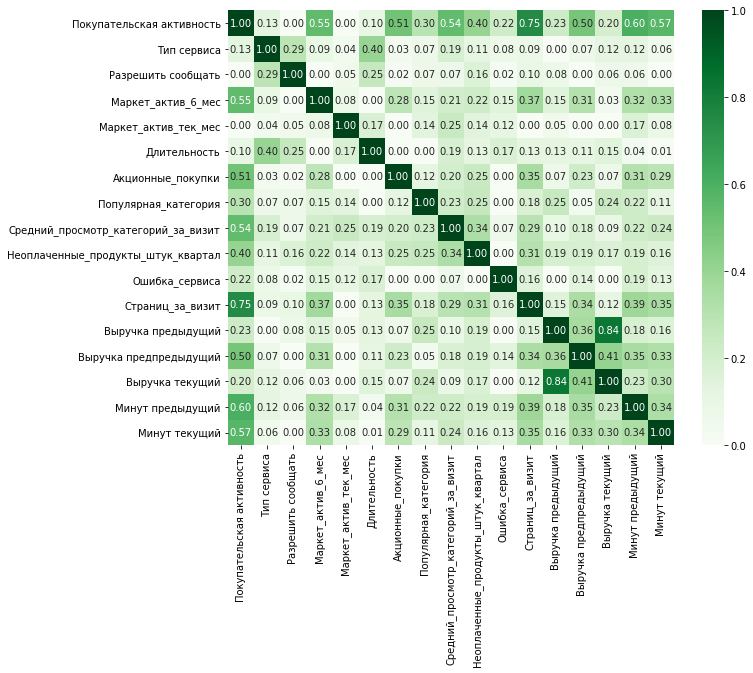

In [51]:
plt.figure(figsize=(10,8))
sns.heatmap(final_data.drop(['id'], axis=1).phik_matrix(interval_cols=['Маркет_актив_6_мес', 
                                                  'Длительность', 
                                                  'Акционные_покупки', 
                                                  'Выручка предпредыдущий', 
                                                  'Выручка предыдущий', 
                                                  'Выручка текущий'], 
                                  ),
           annot=True,
           fmt='.2f',
           cmap='Greens')

Что же, взглянув на матрицу корреляции можно сделать явный вывод о том, что линейных зависимостей между входными признаками практически нет. 
Относительно сильно коррелируют столбцы с выручкой за предыдущий и текущий месяца, но если удалить какой-либо из них, лишимся важной информации.


<a id='pipe'></a>
## Пайплайны.

In [52]:
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']

In [53]:
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',
       'Выручка предыдущий', 'Выручка предпредыдущий', 'Выручка текущий',
       'Минут предыдущий', 'Минут текущий']


X = final_data.drop(['id', 'Покупательская активность'], axis=1)
y = final_data['Покупательская активность']


RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)
#                                                    stratify=y)

Делаем пайплайны:

In [54]:
ohe_pipe = Pipeline([
    ('simpleimputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

In [55]:
ord_pipe = Pipeline([
    ('simpleimputer_beforeOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
        ['стандарт', 'премиум'],
        ['нет', 'да']
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_afterOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE))
])

Теперь создадим большой словарик для того, чтобы перебирать способы масштабирования, модели и их гиперпараметры с помощью случайного поиска по сетке *RandomizedSearch*:

In [56]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,21),
        'models__max_features': range(1, 21),
        'models__min_samples_leaf': range(1,40),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 51),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1')],
        'models__C': range(1,11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [57]:
import warnings
warnings.filterwarnings('ignore')

random_search = RandomizedSearchCV(pipe_final,                           
                           param_grid,
                           cv=5,
                           random_state=RANDOM_STATE,
                           scoring='roc_auc',
                           n_jobs=-1)

In [58]:
random_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_beforeOrd',
                   

In [59]:
f'Метрика recall на тестовой выборке: {recall_score(y_train, random_search.predict(X_train), pos_label="Снизилась")}'

'Метрика recall на тестовой выборке: 0.7119565217391305'

In [60]:
y_test_pred = random_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8476497256024815


Лучшая модель - *DecisionTreeClassifier* с гиперпараметрами:
- max_depth=16
- max_features=18
- min_samples_leaf=36

Её метрика *ROC_AUC*, полученная с помощью кросс-валидации, составила *0.87* - хороший результат. Дальше будем работать с этой моделью. Выбор именно этой метрики обусловлен тем, что, во-первых, классы не сбалансированы, во-вторых, нужно учитывать как ложноположительные, так и ложноотрицательные случаи.

<a id='importance'></a>
## Анализ важности признаков.

Проведем анализ остатков важности признаков, но для начала, построим матрицу ошибок:

<Figure size 1440x1440 with 0 Axes>

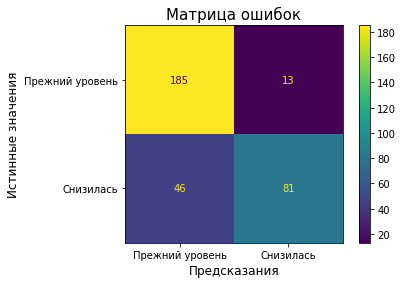

In [61]:
y_pred = random_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(cm, display_labels=random_search.classes_)
disp.plot()
plt.title('Матрица ошибок', fontsize=15)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Истинные значения', fontsize=12)
plt.show()

Из матрицы ошибок становится видно, что, в процентном соотношении, модель чаще выдает ложные позитивные предсказания (*FP*). 

  0%|          | 0/325 [00:00<?, ?it/s]

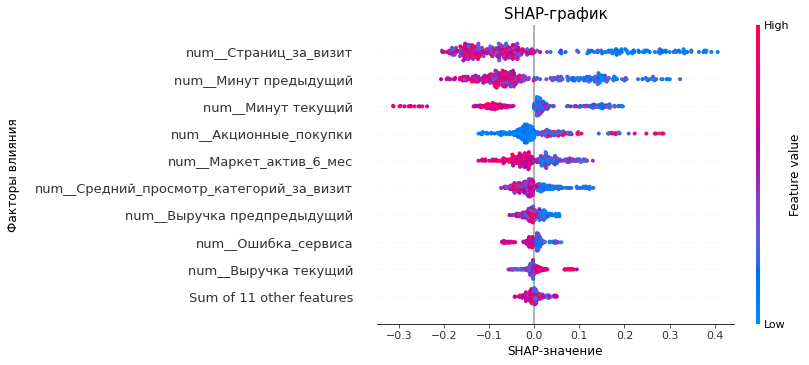

In [62]:
best_pipeline = random_search.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
decision_tree = best_pipeline.named_steps['models']

# Преобразуем данные
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
explainer = shap.SamplingExplainer(lambda x: decision_tree.predict_proba(x)[:,1], X_train_transformed, feature_names=feature_names)
# Вычисляем SHAP-значения
shap_values = explainer(X_test_transformed)
shap_values.feature_names = feature_names
shap.plots.beeswarm(shap_values, show=False)
plt.title('SHAP-график', fontsize=15)
plt.ylabel("Факторы влияния", fontsize=12, labelpad=15)  # `labelpad` регулирует отступ
plt.xlabel("SHAP-значение", fontsize=12)
plt.show()

**Промежуточные выводы**:

Самое сильное влияние на принятие решений модели имеют 9 признаков (в порядке убывания):
- Количество страниц за визит
- Длительность сессий на сайте за предыдущий месяц
- Длительность сессий на сайте в текущем месяце
- Доля акционных покупок
- Количество рассылок от маркета за полгода
- Среднее количество просмотренных категорий за визит
- Выручка за позапрошлый месяц
- Количество ошибок сервиса
- Выручка за текущий месяц

Следовательно, при принятии бизнес-решений надо, в первую очередь опираться на эти признаки, чтобы удержать покупательскую активность у наибольшего числа клиентов. 

<a id='segment'></a>
## Сегментация покупателей

Сегментируем покупателей, используя данные о выручке и вероятности снижения их покупательской активности:

In [63]:
final_data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка предыдущий,Выручка предпредыдущий,Выручка текущий,Минут предыдущий,Минут текущий
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [64]:
X_transformed = preprocessor.transform(X)
final_data['probability'] = decision_tree.predict_proba(X_transformed)[:, 1]

final_data = final_data.merge(money_active, on='id', how='left')
final_data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка предыдущий,Выручка предпредыдущий,Выручка текущий,Минут предыдущий,Минут текущий,probability,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1.000000,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.861111,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1.000000,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1.000000,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.861111,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,0.000000,4.44
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,0.086957,6.11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,0.066667,3.29
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,0.000000,4.03


In [65]:
def segment(row):
    if row['probability'] > 0.7 and row['Прибыль'] > final_data['Прибыль'].median():
        return 'Высокий риск, высокая прибыль'
    elif row['probability'] > 0.7:
        return 'Высокий риск, низкая прибыль'
    elif row['probability'] > 0.4:
        return 'Средний риск'
    else:
        return 'Низкий риск'
    
final_data['Сегмент'] = final_data.apply(segment, axis=1)
final_data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,Выручка предыдущий,Выручка предпредыдущий,Выручка текущий,Минут предыдущий,Минут текущий,probability,Прибыль,Сегмент
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12,10,1.000000,4.16,"Высокий риск, высокая прибыль"
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8,13,0.861111,3.13,"Высокий риск, низкая прибыль"
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11,13,1.000000,4.87,"Высокий риск, высокая прибыль"
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8,11,1.000000,4.21,"Высокий риск, высокая прибыль"
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10,10,0.861111,3.95,"Высокий риск, низкая прибыль"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,...,3,11,3664.0,4704.0,4741.7,14,7,0.000000,4.44,Низкий риск
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,...,3,9,4729.0,5299.0,5353.0,12,11,0.086957,6.11,Низкий риск
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,...,5,7,5160.0,5334.0,5139.2,12,18,0.066667,3.29,Низкий риск
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,...,5,7,4923.0,4725.0,5224.6,18,7,0.000000,4.03,Низкий риск


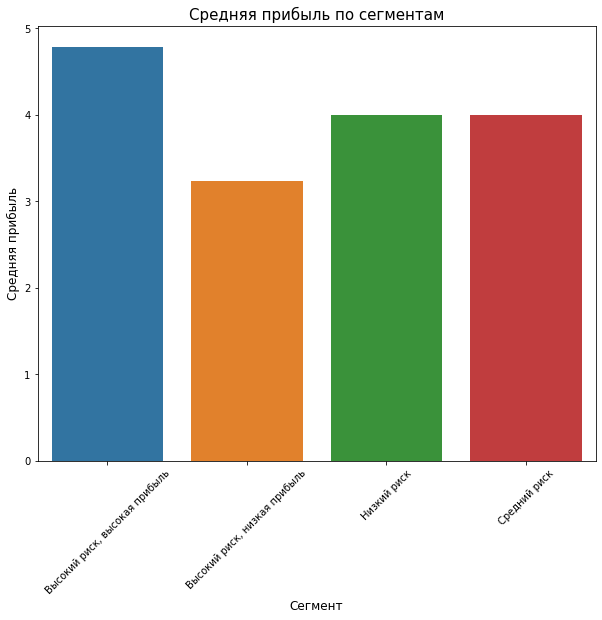

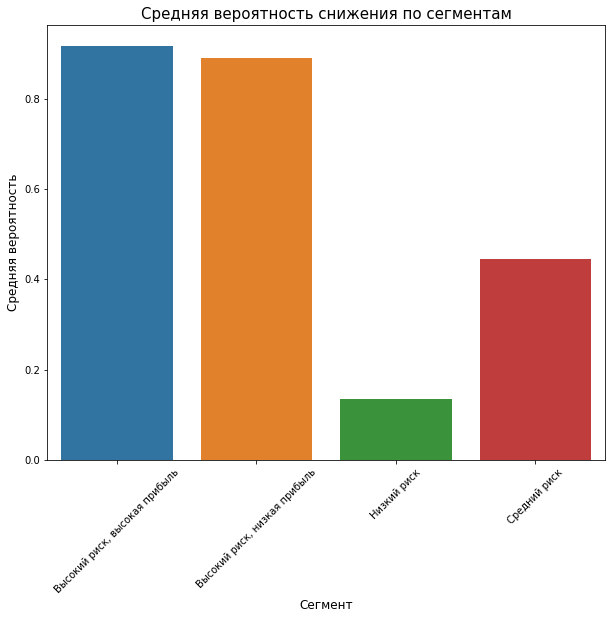

In [66]:
segments = final_data.groupby('Сегмент').agg(count=('id', 'count'),
                                            mean_profit=('Прибыль', 'mean'),
                                             mean_prob=('probability', 'mean')).reset_index()

plt.figure(figsize=(10,8))
sns.barplot(data=segments, x='Сегмент', y='mean_profit')
plt.title('Средняя прибыль по сегментам', fontsize=15)
plt.xlabel('Сегмент', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Средняя прибыль', fontsize=12)
plt.show()

plt.figure(figsize=(10,8))
sns.barplot(data=segments, x='Сегмент', y='mean_prob')
plt.title('Средняя вероятность снижения по сегментам', fontsize=15)
plt.xlabel('Сегмент', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Средняя вероятность', fontsize=12)
plt.show()

Проведем исследование сегмента с высоким риском снижения активности и высокой прибылью:

In [67]:
high_risk_data = final_data.query('Сегмент == "Высокий риск, высокая прибыль"')
high_risk_data.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка предыдущий', 'Выручка предпредыдущий',
       'Выручка текущий', 'Минут предыдущий', 'Минут текущий', 'probability',
       'Прибыль', 'Сегмент'],
      dtype='object')

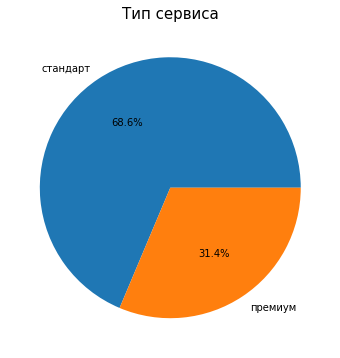

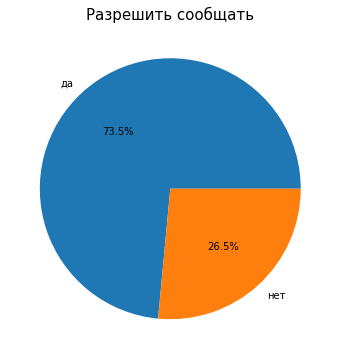

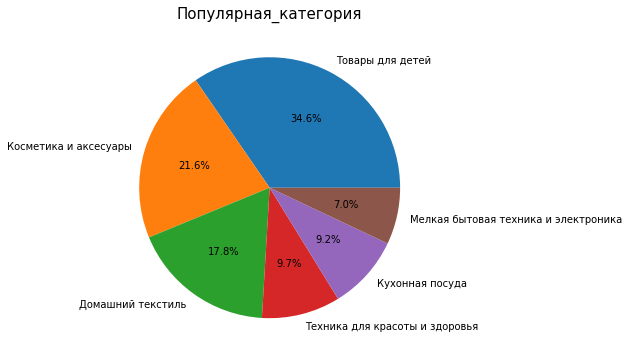

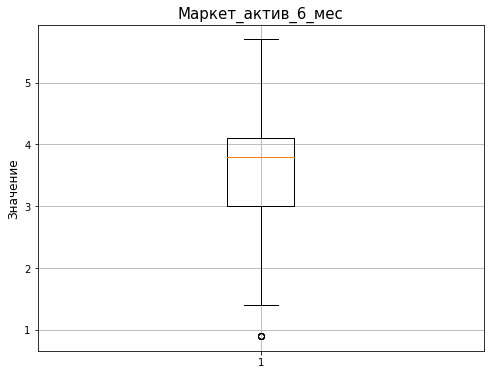

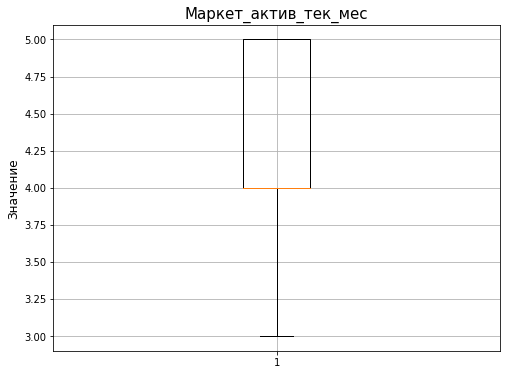

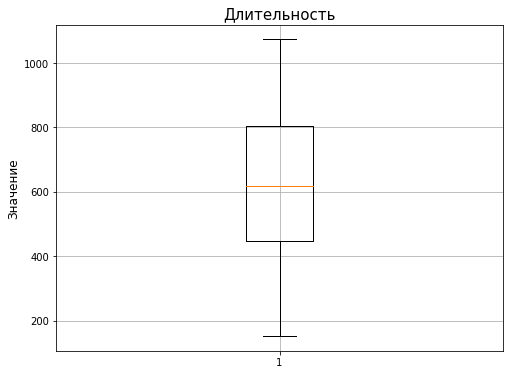

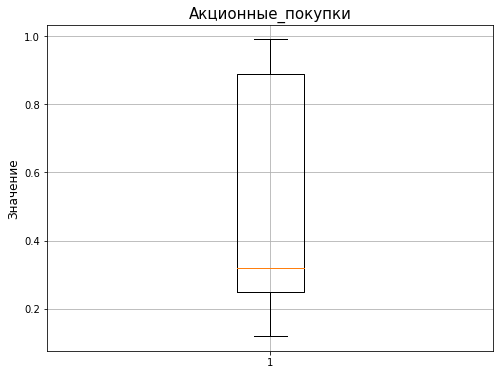

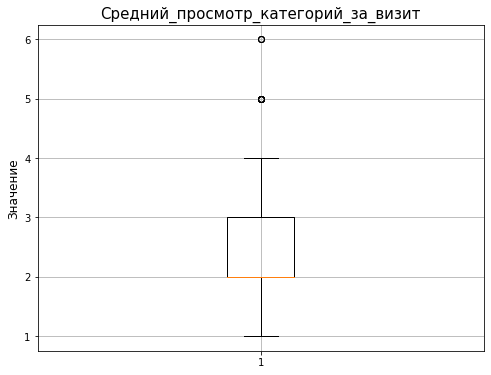

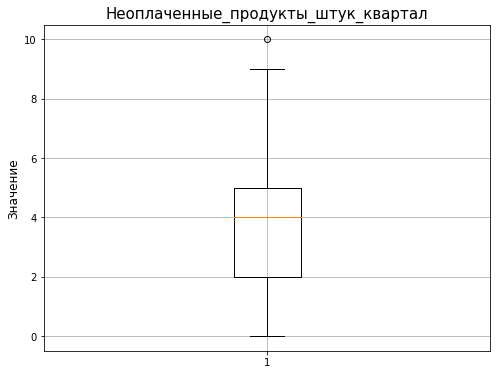

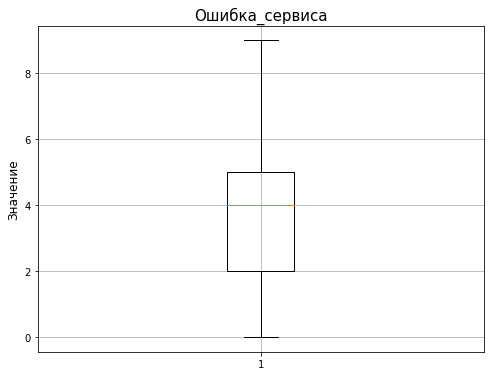

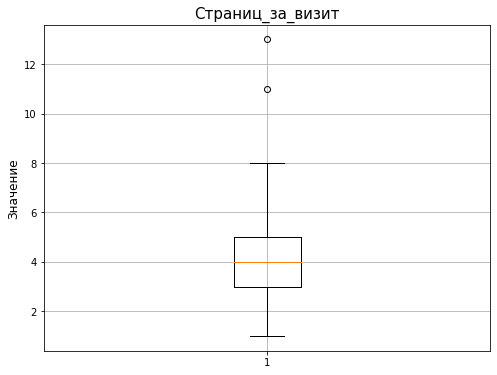

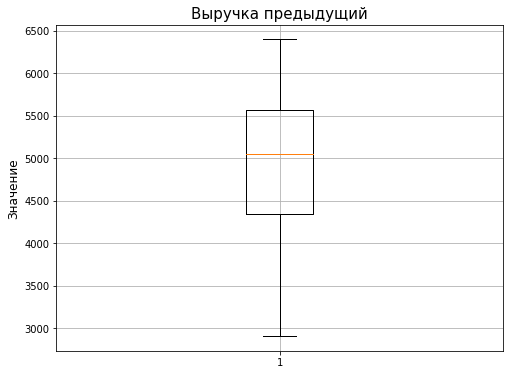

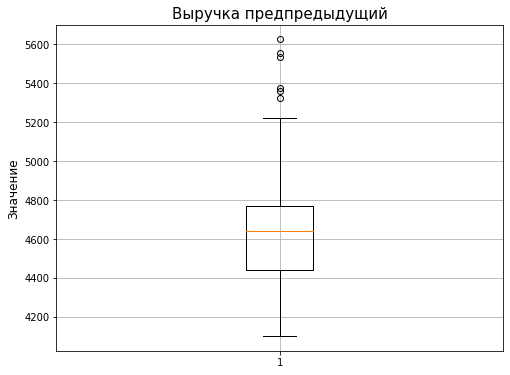

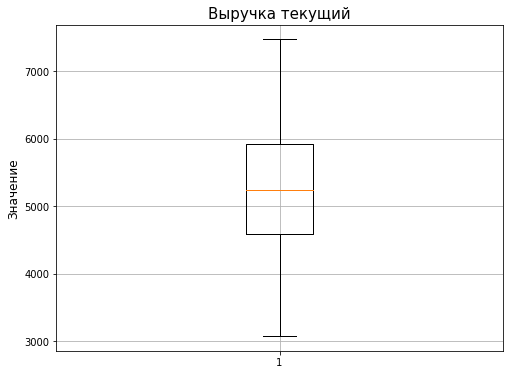

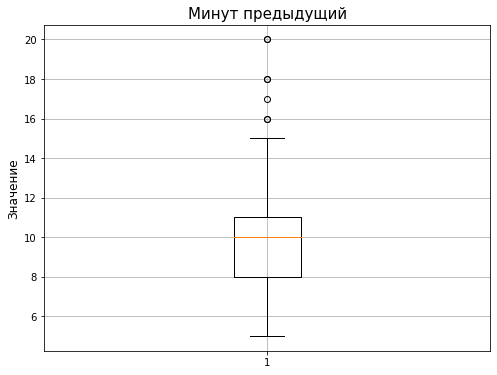

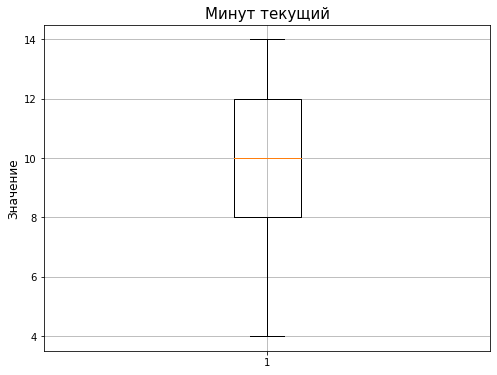

In [68]:
hr_num = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
          'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка предыдущий', 'Выручка предпредыдущий',
       'Выручка текущий', 'Минут предыдущий', 'Минут текущий']

hr_cat = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

for i in hr_cat:
    plt.figure(figsize=(6,6))
    plt.pie(high_risk_data[i].value_counts(), 
            labels=high_risk_data[i].value_counts().index,
            autopct='%1.1f%%' 
           )
    plt.title(i, fontsize=15)
    plt.show()
    
for i in hr_num:
    plt.figure(figsize=(8,6))
    plt.boxplot(high_risk_data[i])
    plt.grid()
    plt.title(i, fontsize=15)
    plt.ylabel('Значение', fontsize=12)
    plt.show()

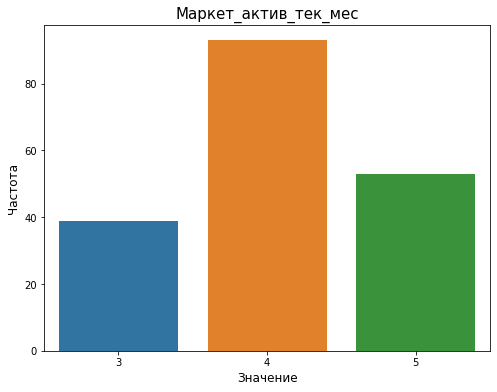

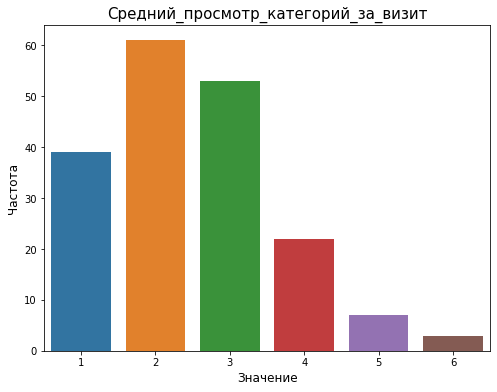

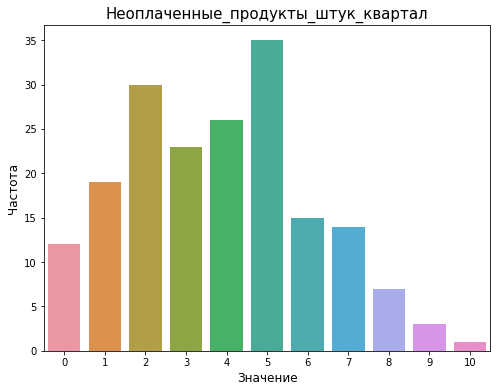

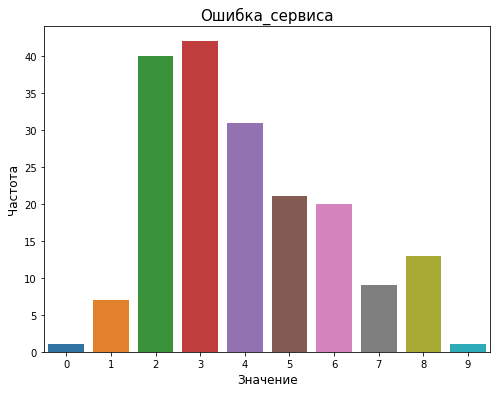

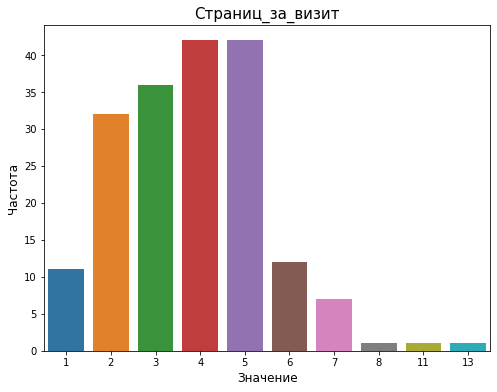

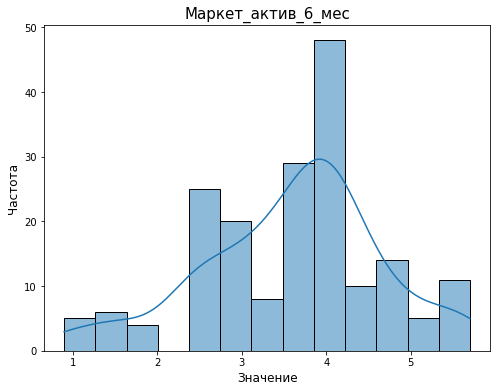

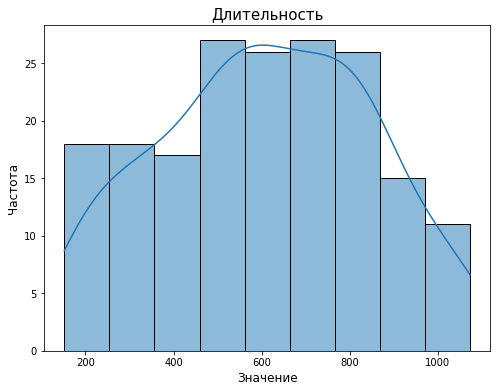

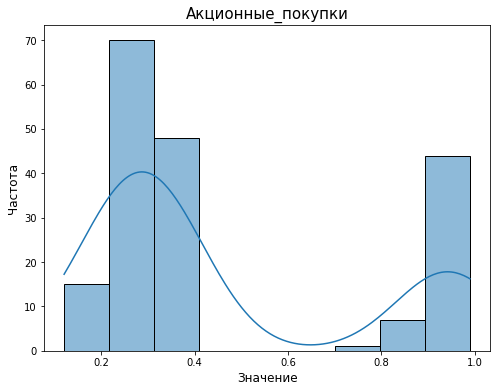

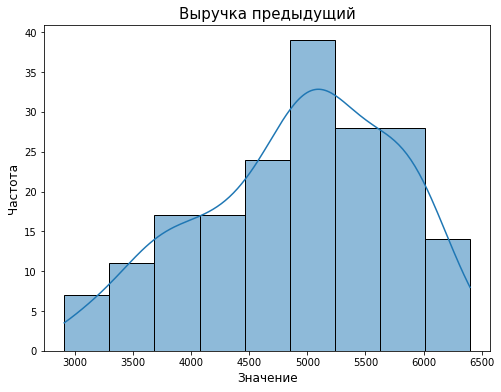

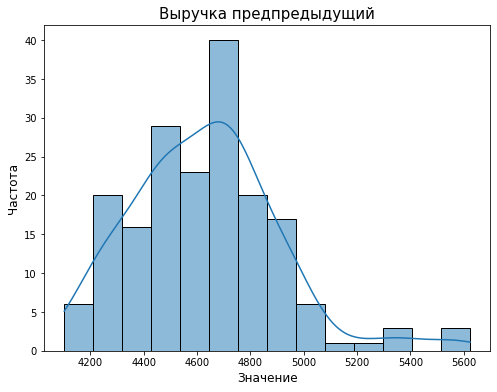

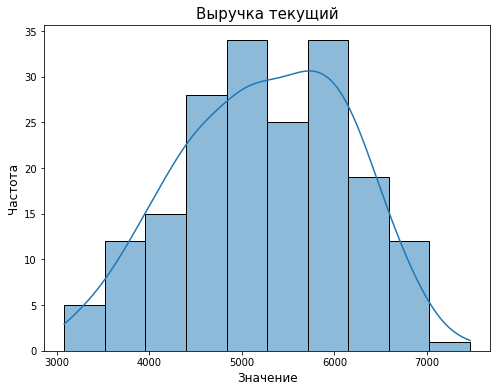

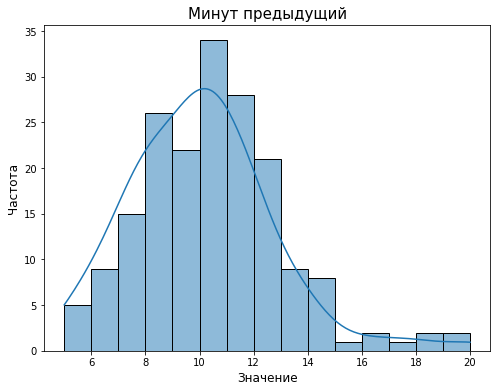

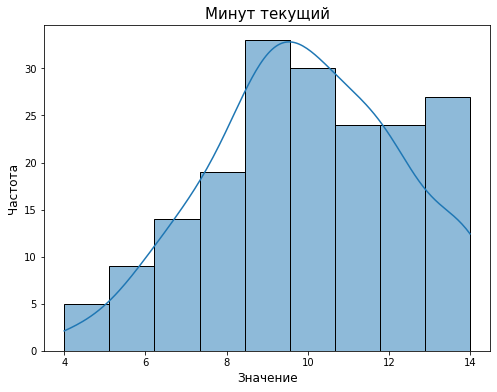

In [69]:
hr_dis = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
         'Страниц_за_визит', ]
hr_cont = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Выручка предыдущий', 'Выручка предпредыдущий',
       'Выручка текущий', 'Минут предыдущий', 'Минут текущий']

for i in hr_dis:
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.countplot(data=high_risk_data, x=i)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

for i in hr_cont:
    plt.figure(figsize=(8,6))
    plt.title(i, fontsize=15)
    sns.histplot(data=high_risk_data, x=i, kde=True)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

Особенно явных отличий выбранного сегмента (с высоким риском снижения активности и высокой прибылью) от данных по всем клиентам не наблюдается, но нужно отметить некоторые вещи:

- Самая популярная категория это *Товары для детей*, на втором *Косметика и аксессуары*. Можно предположить, что детям нужен не бесконечный пул вещей, а лишь некоторый набор, поэтому, рано или поздно, от таких клиентов прибыль упадет в любом случае. С косметикой и аксессуарами объяснить сложнее, но, возможно, причина похожа на первый случай.
- Чаще всего в корзине лежат неоплаченными *2 или 5* товаров.
- У доли акционных покупок есть небольшой пик в районе единицы. То есть ощутимое число пользователей среди этого сегмента покупают только товары по акции
- Среднее количество минут на сайте в текущем месяце по сравнению с предыдущим увеличилось, то есть пользователи тратят больше времени на то, чтобы что-то найти, возможно, покупают уже более вдумчиво.

Бизнес-предложения по работе с сегментом:
- Расширить ассортимент товаров в двух самых популярных категорияъ (*Товары для детей и Косметика с акссесуарами*).
- Если есть возможность, то каким-нибудь образом вводить скидки или давать промокоды на неоплаченные товары и корзины.

<a id='res'></a>
## Итоговые выводы.

В ходе проекта были обработаны и исследованы данные, предоставленные интернет-магазином "В один клик". На их основе была построена модель машинного обучения, которая с высокой точностью позволит предсказать, какие клиенты останутся активными покупателями, а у каких клиентов активность снизится.

**Предобработка**

Сперва, данные были загружены и предварительно обработаны. В ходе [предобработки](#prep) выяснилось, что все предоставленные данные оказались достаточно чистыми, однако, кое-что пришлось подправить - тип значений у выручки (первый датасет *market_file*), неявный дубликат у типа сервиса (первый датасет *market_file*), а также исправлена небольшая опечатка в столбце периода (датасет *market_time*). 

**Исследовательский анализ**

После предобработки данных был выполнен [исследовательский анализ](#research), который показал следующее:

Датасет *market_file*:

*Качественные признаки*:
- Почти у 40% клиентов активность снизилась.
- Большинство клиентов используют стандартный тип сервиса (более 70%).
- Большинство клиентов получают рассылки (более 70%).
- Популярные категории не сильно отличаются между собой по количеству, тем не менее, самая большая - "Товары для детей" (25.4%), самая маленькая - "Мелкая бытовая техника и электроника" (13.4%).

*Количественные признаки*:
- В среднем, за последние полгода клиенты получали по 4 рассылки, в текущем месяце ситуация аналогичная, выбросов единицы.
- Медианное значение дней, сколько пользователь зарегистрирован на сайте - 600.
- Медианное значение доли акционных покупок за месяц - в районе 25%, есть небольшое количество выбросов. 
- За месяц пользователи просматривают в среднем 3 категории за визит.
- Неоплаченных товаров за последние три месяца в корзинах в среднем остается около трех.
- За последние три месяца медианное количество сбоев при нахождении на сайте - 125.
- Среднее количество просмотренных страниц за визит - в районе 8.

Датасет *market_money*:

- Три периода: предпредыдущий месяц, предыдущий и текущий, для каждого пользователя в равном соотношении.
- Медианное значение выручки - около 5000 условных единиц. Нельзя не отметить, что был единичный сильный выброс, значение которого составило 106862 единицы. Это может быть как ошибка в данных, так и действительно шопоголик.

Датасет *market_time*:

- Два периода - предыдущий и текущий месяцы.
- Медианное значение минут, сколько пользователи проводят на сайте - 13.

Датасет *money*:

- Медианное значение прибыли - 4 условные единицы.

Стоит отметить, что во всех количественных признаках если и были выбросы, то их было немного, что не моглот не радовать.

После исследовательского анализа понадобилось отобрать только активных клиентов - тех, кто совершал покупки хотя бы в один из трех послежних месяцев, включая текущий. Выяснилось, что таковыми являлись практически все клиенты - из предоставленных *1300* активными оказались *1297*.

**Объединение таблиц**

Затем, для удобства работы, все таблицы были [объединены](#merge), а периоды с выручкой и временем на сайте вынесены в отдельные столбцы. Результатом объединения стал датасет *final_data*.

**Корреляционный анализ**

После объединения был выполнен [корреляционный анализ](#corr), а именно - была построена матрица корреляции для всех признаков в итоговом датасете. Матрица корреляции показала, что линейных зависимостей между входными признаками практически нет. 
Относительно сильно коррелировали столбцы с выручкой за предыдущий и текущий месяца, но они не были удалены, так как это важная информация, избавление от которой могло сильно ухудшить прогнозы.

**Построение пайплайнов**

Следующим шагом в проекте стало создание [пайплайнов](#pipe) и выбор с их помощью наиболее точной модели машинного обучения с самыми подходящими гиперпараметрами. Таковой оказалось дерево решений (*DecisionTreeModel*) со следующими гиперпараметрами:
- max_depth=16
- max_features=18
- min_samples_leaf=36

Её метрика *ROC_AUC* на кросс-валидационной выборке составила *0.87* - хороший результат. Далее использовалась именно эта модель. Выбор метрики *ROCaAUC* обусловлен тем, что, во-первых, классы не сбалансированы, во-вторых, нужно учитывать как ложноположительные, так и ложноотрицательные случаи.

**Анализ важности признаков**

После выбора самой точной модели был проведен [анализ важности признаков](#importance). Была построена матрица ошибок, которая показала, что, в процентном соотношении, модель чаще выдавала ложные позитивные предсказания (*FP*). После этого, был построен *SHAP- график*, который показал, на какие признаки модель опирается сильнее всего при своей работе. Самое сильное влияние на принятие решений модели имели 9 признаков (в порядке убывания):
- Количество страниц за визит
- Длительность сессий на сайте за предыдущий месяц
- Длительность сессий на сайте в текущем месяце
- Доля акционных покупок
- Количество рассылок от маркета за полгода
- Среднее количество просмотренных категорий за визит
- Выручка за позапрошлый месяц
- Количество ошибок сервиса
- Выручка за текущий месяц

Следовательно, при принятии бизнес-решений интернет-магазину *В один клик* надо, в первую очередь, опираться на эти признаки, чтобы удержать покупательскую активность у наибольшего числа клиентов. 

**Сегментация покупателей**

Финальным этапом проекта стало [исследование отдельного сегмента](#segment) покупателей. Опираясь на полученные прогнозы и данные с прибылью, пользователи были сегментированы на 4 группы:
- Высокий риск снижения активности и высокая прибыль
- Высокий риск снижения активности и низкая прибыль
- Средний риск снижения активности
- Низкий риск снижения активности

Для исследования был выбран первый сегмент. Выяснилось, что явных отличий выбранного сегмента (с высоким риском снижения активности и высокой прибылью) от данных по всем клиентам не наблюдается, но нужно отметить некоторые вещи:

- Самая популярная категория это *Товары для детей*, на втором *Косметика и аксессуары*. Можно предположить, что детям нужен не бесконечный пул вещей, а лишь некоторый набор, поэтому, рано или поздно, от таких клиентов прибыль упадет в любом случае. С косметикой и аксессуарами объяснить сложнее, но, возможно, причина похожа на первый случай.
- Чаще всего в корзине лежат неоплаченными *2 или 5* товаров.
- У доли акционных покупок есть небольшой пик в районе единицы. То есть ощутимое число пользователей среди этого сегмента покупают только товары по акции
- Среднее количество минут на сайте в текущем месяце по сравнению с предыдущим увеличилось, то есть пользователи тратят больше времени на то, чтобы что-то найти, возможно, покупают уже более вдумчиво.

Бизнес-предложения по работе с сегментом:
- Расширить ассортимент товаров в двух самых популярных категорияъ (*Товары для детей и Косметика с акссесуарами*).
- Если есть возможность, то каким-нибудь образом вводить скидки или давать промокоды на неоплаченные товары и корзины.

**Финальные предложения**

- Попытаться перевести пользователей исследованного сегмента на премиумный тип сервиса.
- Увеличить количество акций на товары соответствующих категорий.

*(+ для исследованного сегмента постараться реализовать вышеизложенные предложения)*

Таким образом, магазин будет получать больший доход (из премиумного сервиса), а клиенты останутся активными (из-за акций на товары соответствующих категорий).